# CLAP Score Analysis

This notebook analyzes the CLAP (Contrastive Language-Audio Pretraining) scores from the TTA (Text-to-Audio) generation results to understand:
1. Distribution of CLAP scores
2. Correlation between aspect count and CLAP score
3. Correlation between prediction length and CLAP score
4. Which aspects have positive or negative influence on CLAP scores

## 1. Import Required Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import pearsonr+
import ast

# Set style for better visualizations
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.dpi'] = 100

## 2. Load and Explore the Dataset

In [2]:
# Load the dataset
df = pd.read_csv('../outputs/tta/best_sweep/per_sample_scores.csv')

# Display basic information
print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nData types:\n{df.dtypes}")
print(f"\nBasic statistics for CLAP score:")
print(df['clap_score'].describe())

Dataset shape: (357, 8)

Columns: ['id', 'aspect_list', 'prediction', 'perplexity', 'llm_judge_score', 'llm_judge_reasoning', 'filename', 'clap_score']

Data types:
id                      object
aspect_list             object
prediction              object
perplexity             float64
llm_judge_score        float64
llm_judge_reasoning     object
filename                object
clap_score             float64
dtype: object

Basic statistics for CLAP score:
count    357.000000
mean       0.316317
std        0.228050
min        0.003748
25%        0.130461
50%        0.271952
75%        0.461749
max        0.988329
Name: clap_score, dtype: float64


In [3]:
# Display first few rows
df.head()

,id,aspect_list,prediction,perplexity,llm_judge_score,llm_judge_reasoning,filename,clap_score
0,cb2cb697bc5bea9d0daf0e36e69d1c32,"['acoustic drums', 'female singer', 'inspiring...",The uplifting anthem features an acoustic drum...,11.821788,8.0,"The description is highly accurate, coherent, ...",cb2cb697bc5bea9d0daf0e36e69d1c32.wav,0.225930
1,718b25e382eab658978ba85233139769,"['slow tempo', 'soothing', 'trumpets']","The melancholic ballad ""Echoes in Twilight"" be...",6.365511,8.0,The description accurately incorporates the gi...,718b25e382eab658978ba85233139769.wav,0.282681
2,1a02eb08a3ef4478f3a8f6fdb5910c57,"['drums', 'flat male vocal', 'fun', 'groovy ba...",The upbeat track begins with an infectious gro...,7.430776,8.0,The description accurately incorporates all th...,1a02eb08a3ef4478f3a8f6fdb5910c57.wav,0.271952
3,b05607cf8dfb21a45c370b1836699729,"['digital drums', 'medium tempo', 'spiritual']","""Echoes in Eternity"" is an atmospheric electro...",7.569702,9.0,Considering the high quality of the descriptio...,b05607cf8dfb21a45c370b1836699729.wav,0.016250
4,594a9d268c2c738ebea298e72ad6efcf,"['folk', 'fun', 'male vocalist', 'soft']",This folk-inspired ballad features a soft-spok...,7.886882,8.0,The description accurately incorporates the gi...,594a9d268c2c738ebea298e72ad6efcf.wav,0.470630


## 3. Plot Distribution of CLAP Scores

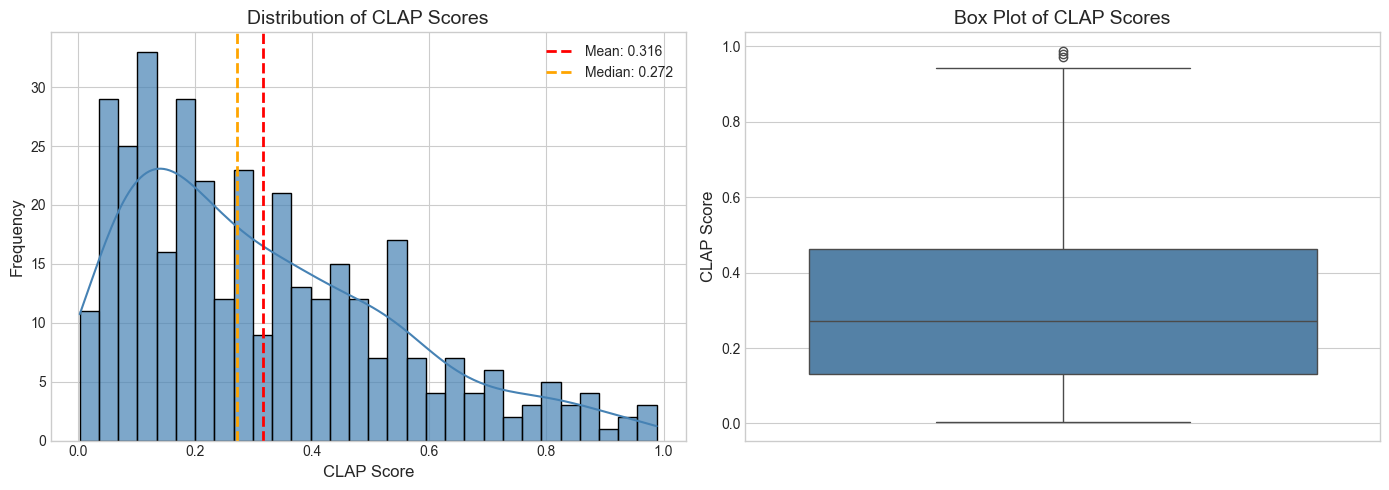


CLAP Score Statistics:
  Mean: 0.3163
  Median: 0.2720
  Std Dev: 0.2281
  Min: 0.0037
  Max: 0.9883


In [4]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram with KDE
ax1 = axes[0]
sns.histplot(df['clap_score'], kde=True, bins=30, ax=ax1, color='steelblue', alpha=0.7)
ax1.axvline(df['clap_score'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {df["clap_score"].mean():.3f}')
ax1.axvline(df['clap_score'].median(), color='orange', linestyle='--', linewidth=2, label=f'Median: {df["clap_score"].median():.3f}')
ax1.set_xlabel('CLAP Score', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.set_title('Distribution of CLAP Scores', fontsize=14)
ax1.legend()

# Box plot
ax2 = axes[1]
sns.boxplot(y=df['clap_score'], ax=ax2, color='steelblue')
ax2.set_ylabel('CLAP Score', fontsize=12)
ax2.set_title('Box Plot of CLAP Scores', fontsize=14)

plt.tight_layout()
plt.show()

print(f"\nCLAP Score Statistics:")
print(f"  Mean: {df['clap_score'].mean():.4f}")
print(f"  Median: {df['clap_score'].median():.4f}")
print(f"  Std Dev: {df['clap_score'].std():.4f}")
print(f"  Min: {df['clap_score'].min():.4f}")
print(f"  Max: {df['clap_score'].max():.4f}")

## 4. Analyze Correlation: Aspect Count vs CLAP Score

Let's examine if the number of aspects (tags) in the prompt affects the CLAP score.

In [5]:
# Parse aspect_list and count aspects
def parse_aspect_list(aspect_str):
    try:
        return ast.literal_eval(aspect_str)
    except:
        return []

df['aspects_parsed'] = df['aspect_list'].apply(parse_aspect_list)
df['aspect_count'] = df['aspects_parsed'].apply(len)

print(f"Aspect count statistics:")
print(df['aspect_count'].describe())

Aspect count statistics:
count    357.000000
mean       7.492997
std        4.003240
min        3.000000
25%        5.000000
50%        7.000000
75%        9.000000
max       29.000000
Name: aspect_count, dtype: float64


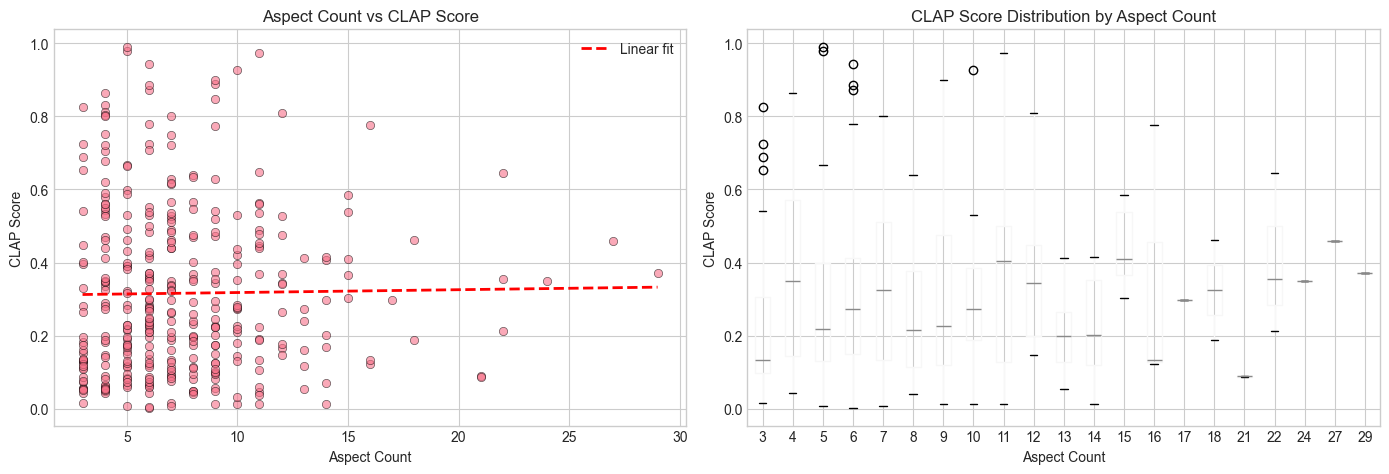


Pearson Correlation: 0.0136
P-value: 7.9842e-01
Interpretation: Not significant correlation at α=0.05


In [6]:
# Scatter plot: Aspect Count vs CLAP Score
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter plot with regression line
axes[0].scatter(df['aspect_count'], df['clap_score'], alpha=0.6, edgecolors='black', linewidth=0.5)
z = np.polyfit(df['aspect_count'], df['clap_score'], 1)
p = np.poly1d(z)
x_line = np.linspace(df['aspect_count'].min(), df['aspect_count'].max(), 100)
axes[0].plot(x_line, p(x_line), "r--", linewidth=2, label=f'Linear fit')
axes[0].set_xlabel('Aspect Count')
axes[0].set_ylabel('CLAP Score')
axes[0].set_title('Aspect Count vs CLAP Score')
axes[0].legend()

# Box plot by aspect count
df.boxplot(column='clap_score', by='aspect_count', ax=axes[1])
axes[1].set_xlabel('Aspect Count')
axes[1].set_ylabel('CLAP Score')
axes[1].set_title('CLAP Score Distribution by Aspect Count')
plt.suptitle('')

plt.tight_layout()
plt.show()

# Calculate Pearson correlation
correlation, p_value = pearsonr(df['aspect_count'], df['clap_score'])
print(f"\nPearson Correlation: {correlation:.4f}")
print(f"P-value: {p_value:.4e}")
print(f"Interpretation: {'Significant' if p_value < 0.05 else 'Not significant'} correlation at α=0.05")

## 5. Analyze Correlation: Prediction Length vs CLAP Score

In [7]:
# Calculate prediction length (character count)
df['prediction_length'] = df['prediction'].apply(len)

print(f"Prediction length statistics:")
print(df['prediction_length'].describe())

Prediction length statistics:
count     357.000000
mean     1044.655462
std       227.647400
min       135.000000
25%       881.000000
50%      1049.000000
75%      1227.000000
max      1565.000000
Name: prediction_length, dtype: float64


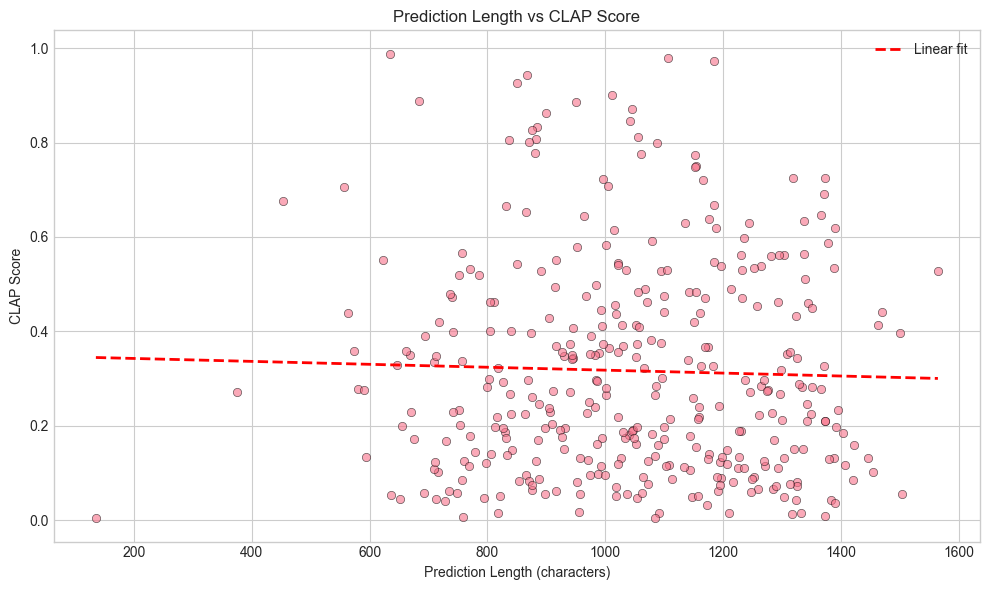


Pearson Correlation: -0.0310
P-value: 5.5988e-01
Interpretation: Not significant correlation at α=0.05


In [8]:
# Scatter plot: Prediction Length vs CLAP Score
fig, ax = plt.subplots(figsize=(10, 6))

ax.scatter(df['prediction_length'], df['clap_score'], alpha=0.6, edgecolors='black', linewidth=0.5)

# Add regression line
z = np.polyfit(df['prediction_length'], df['clap_score'], 1)
p = np.poly1d(z)
x_line = np.linspace(df['prediction_length'].min(), df['prediction_length'].max(), 100)
ax.plot(x_line, p(x_line), "r--", linewidth=2, label='Linear fit')

ax.set_xlabel('Prediction Length (characters)')
ax.set_ylabel('CLAP Score')
ax.set_title('Prediction Length vs CLAP Score')
ax.legend()

plt.tight_layout()
plt.show()

# Calculate Pearson correlation
correlation, p_value = pearsonr(df['prediction_length'], df['clap_score'])
print(f"\nPearson Correlation: {correlation:.4f}")
print(f"P-value: {p_value:.4e}")
print(f"Interpretation: {'Significant' if p_value < 0.05 else 'Not significant'} correlation at α=0.05")

## 6. Aspect Influence Analysis

Analyze which specific aspects have positive or negative influence on CLAP scores.

In [9]:
# Extract all unique aspects and their associated CLAP scores
aspect_scores = {}

for _, row in df.iterrows():
    aspects = row['aspects_parsed']
    clap_score = row['clap_score']
    
    for aspect in aspects:
        if aspect not in aspect_scores:
            aspect_scores[aspect] = []
        aspect_scores[aspect].append(clap_score)

# Calculate mean CLAP score for each aspect
aspect_stats = []
for aspect, scores in aspect_scores.items():
    aspect_stats.append({
        'aspect': aspect,
        'mean_clap_score': np.mean(scores),
        'std_clap_score': np.std(scores),
        'count': len(scores)
    })

aspect_df = pd.DataFrame(aspect_stats)
aspect_df = aspect_df.sort_values('mean_clap_score', ascending=False)

print(f"Number of unique aspects: {len(aspect_df)}")
print(f"\nOverall mean CLAP score: {df['clap_score'].mean():.4f}")
print(f"\nTop 10 aspects by mean CLAP score:")
aspect_df.head(10)

Number of unique aspects: 175

Overall mean CLAP score: 0.3163

Top 10 aspects by mean CLAP score:


,aspect,mean_clap_score,std_clap_score,count
172,beat boxing,0.899771,0.000000,1
44,hard rock,0.652047,0.244047,7
153,slick drumming rhythm,0.647851,0.239174,2
155,metal,0.595825,0.234519,3
165,dramatic,0.587989,0.355117,2
82,heavy metal,0.545563,0.265050,4
145,latin dance music,0.535173,0.000000,1
174,groovy double bass,0.526768,0.000000,1
113,dance rhythm,0.524136,0.193291,6
43,e-guitar,0.504580,0.298054,9


In [10]:
# Bottom 10 aspects by mean CLAP score
print("Bottom 10 aspects by mean CLAP score:")
aspect_df.tail(10)

Bottom 10 aspects by mean CLAP score:


,aspect,mean_clap_score,std_clap_score,count
72,rhythmic,0.158431,0.037138,2
60,ballad,0.153842,0.153712,3
123,guitar solo,0.142612,0.105142,10
135,slower tempo,0.113743,0.000000,1
170,psychedelic,0.109256,0.007214,2
20,spiritual,0.096406,0.050150,4
94,sad,0.095032,0.056609,6
144,beatboxing,0.062567,0.000000,1
147,scary,0.060540,0.046084,2
173,gospel,0.008335,0.000000,1


Aspects with at least 3 samples: 145


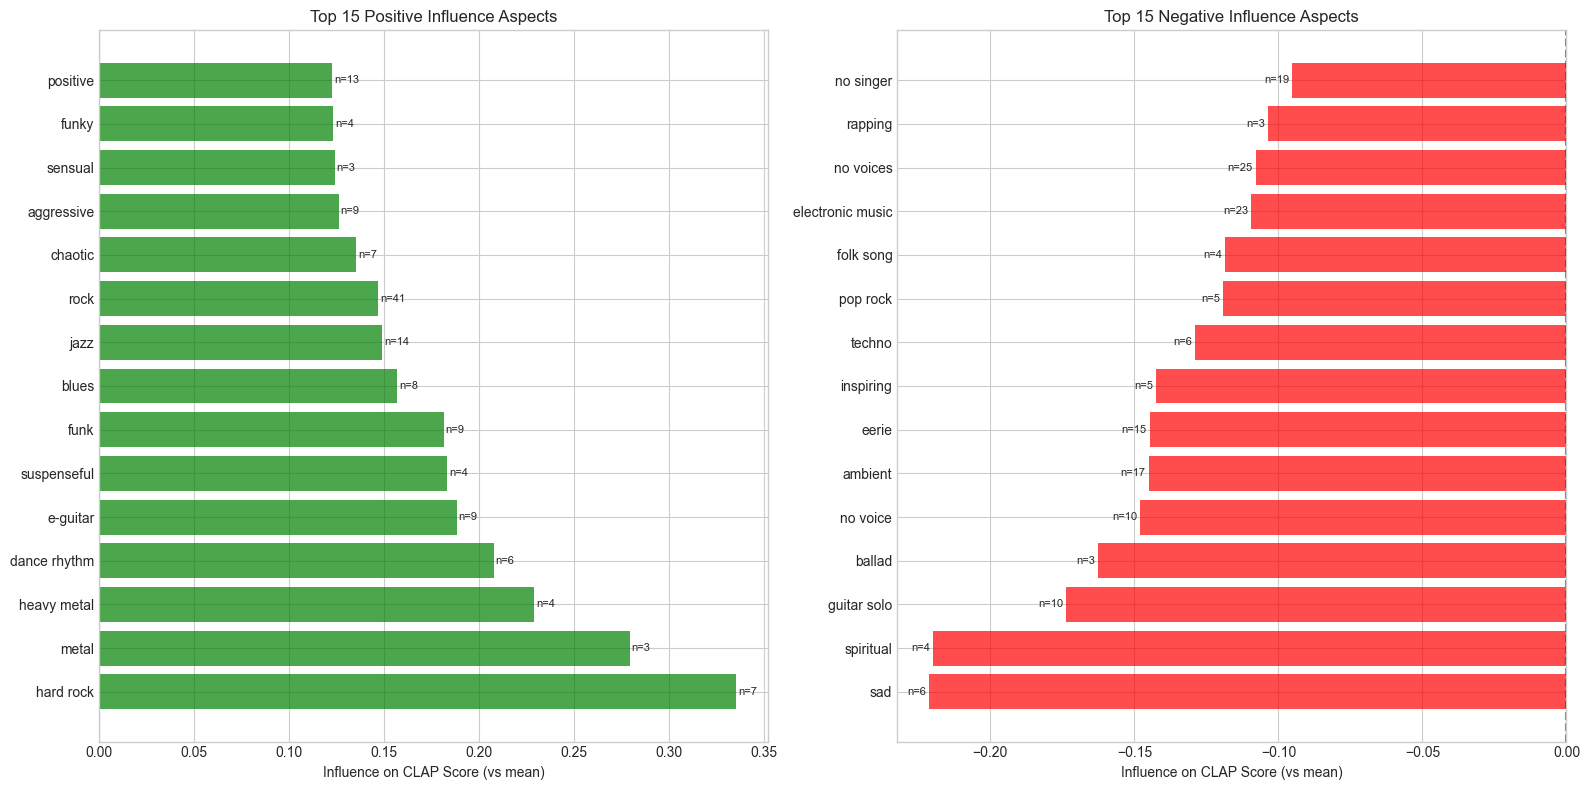

In [11]:
# Calculate influence score (deviation from overall mean)
overall_mean = df['clap_score'].mean()
aspect_df['influence'] = aspect_df['mean_clap_score'] - overall_mean

# Filter aspects with sufficient samples (at least 3 occurrences)
min_samples = 3
aspect_df_filtered = aspect_df[aspect_df['count'] >= min_samples].copy()

print(f"Aspects with at least {min_samples} samples: {len(aspect_df_filtered)}")

# Visualize top positive and negative influencers
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Top positive influencers
top_positive = aspect_df_filtered.nlargest(15, 'influence')
axes[0].barh(top_positive['aspect'], top_positive['influence'], color='green', alpha=0.7)
axes[0].set_xlabel('Influence on CLAP Score (vs mean)')
axes[0].set_title('Top 15 Positive Influence Aspects')
axes[0].axvline(x=0, color='black', linestyle='--', alpha=0.5)
for i, (idx, row) in enumerate(top_positive.iterrows()):
    axes[0].text(row['influence'] + 0.001, i, f"n={row['count']}", va='center', fontsize=8)

# Top negative influencers
top_negative = aspect_df_filtered.nsmallest(15, 'influence')
axes[1].barh(top_negative['aspect'], top_negative['influence'], color='red', alpha=0.7)
axes[1].set_xlabel('Influence on CLAP Score (vs mean)')
axes[1].set_title('Top 15 Negative Influence Aspects')
axes[1].axvline(x=0, color='black', linestyle='--', alpha=0.5)
for i, (idx, row) in enumerate(top_negative.iterrows()):
    axes[1].text(row['influence'] - 0.001, i, f"n={row['count']}", va='center', ha='right', fontsize=8)

plt.tight_layout()
plt.show()

In [12]:
# Statistical significance test for aspect influence
# Using t-test to compare each aspect's scores against overall mean
from scipy.stats import ttest_1samp

significant_aspects = []

for _, row in aspect_df_filtered.iterrows():
    aspect = row['aspect']
    scores = aspect_scores[aspect]
    
    if len(scores) >= min_samples:
        t_stat, p_value = ttest_1samp(scores, overall_mean)
        significant_aspects.append({
            'aspect': aspect,
            'mean_clap_score': row['mean_clap_score'],
            'influence': row['influence'],
            'count': row['count'],
            't_statistic': t_stat,
            'p_value': p_value,
            'significant': p_value < 0.05
        })

significant_df = pd.DataFrame(significant_aspects)
significant_df = significant_df.sort_values('p_value')

print(f"Statistically significant aspects (p < 0.05):")
sig_only = significant_df[significant_df['significant']]
print(f"Found {len(sig_only)} significant aspects out of {len(significant_df)}\n")
sig_only

Statistically significant aspects (p < 0.05):
Found 24 significant aspects out of 145



,aspect,mean_clap_score,influence,count,t_statistic,p_value,significant
139,ambient,0.171239,-0.145079,17,-5.277158,0.000075,True
144,sad,0.095032,-0.221286,6,-8.740916,0.000325,True
142,guitar solo,0.142612,-0.173706,10,-4.956317,0.000784,True
132,no voices,0.208439,-0.107878,25,-3.809153,0.000852,True
9,rock,0.463422,0.147104,41,3.352016,0.001762,True
143,spiritual,0.096406,-0.219912,4,-7.595234,0.004736,True
135,pop rock,0.196963,-0.119355,5,-5.312473,0.006036,True
124,electronic drums,0.234612,-0.081706,34,-2.774323,0.009034,True
133,electronic music,0.206948,-0.109370,23,-2.721987,0.012448,True
23,happy,0.405631,0.089313,31,2.626948,0.013440,True


## 7. Summary Statistics

In [13]:
# Summary of findings
print("=" * 60)
print("CLAP SCORE ANALYSIS SUMMARY")
print("=" * 60)

print(f"\n📊 Dataset Overview:")
print(f"   Total samples: {len(df)}")
print(f"   Unique aspects: {len(aspect_df)}")

print(f"\n📈 CLAP Score Statistics:")
print(f"   Mean: {df['clap_score'].mean():.4f}")
print(f"   Median: {df['clap_score'].median():.4f}")
print(f"   Std: {df['clap_score'].std():.4f}")
print(f"   Min: {df['clap_score'].min():.4f}")
print(f"   Max: {df['clap_score'].max():.4f}")

# Aspect count correlation
corr_aspect, p_aspect = pearsonr(df['aspect_count'], df['clap_score'])
print(f"\n🔗 Aspect Count vs CLAP Score:")
print(f"   Correlation: {corr_aspect:.4f} (p={p_aspect:.4e})")

# Prediction length correlation
corr_length, p_length = pearsonr(df['prediction_length'], df['clap_score'])
print(f"\n📝 Prediction Length vs CLAP Score:")
print(f"   Correlation: {corr_length:.4f} (p={p_length:.4e})")

print(f"\n🎯 Aspect Influence:")
print(f"   Aspects with significant positive influence: {len(sig_only[sig_only['influence'] > 0])}")
print(f"   Aspects with significant negative influence: {len(sig_only[sig_only['influence'] < 0])}")

print("\n" + "=" * 60)

CLAP SCORE ANALYSIS SUMMARY

📊 Dataset Overview:
   Total samples: 357
   Unique aspects: 175

📈 CLAP Score Statistics:
   Mean: 0.3163
   Median: 0.2720
   Std: 0.2281
   Min: 0.0037
   Max: 0.9883

🔗 Aspect Count vs CLAP Score:
   Correlation: 0.0136 (p=7.9842e-01)

📝 Prediction Length vs CLAP Score:
   Correlation: -0.0310 (p=5.5988e-01)

🎯 Aspect Influence:
   Aspects with significant positive influence: 7
   Aspects with significant negative influence: 17

